In [1]:
from file import test_complete_system
import numpy as np
from substitute_perbutate import FresnelSubstitution , PixelPerturbation
from PIL import Image
import matplotlib.pyplot as plt

COMBINED ENCRYPTION: SUBSTITUTION + PERTURBATION
Implementation from the research paper

Usage:
  # Perform combined encryption and decryption
  original, substituted, perturbed, inv_perturbed, recovered = \
      combined_encryption('your_image.jpg')

  # Visualize all stages
  visualize_combined_encryption(original, substituted, perturbed, \
                                 inv_perturbed, recovered)


In [2]:

def combined_encryption(image_path, seed_d=12345, seed_f=67890, r=3.99, x=0.5):
    """
    Combined encryption: Substitution -> Perturbation -> Inverse Perturbation -> Inverse Substitution
    
    
    Args:
        image_path: Path to the input image
        seed_d: Seed for distance parameter (substitution)
        seed_f: Seed for frequency parameter (substitution)
        r: Logistic map parameter (perturbation)
        x: Initial value for logistic map (perturbation)
        
    Returns:
        original_img, after_substitution, after_perturbation, after_inv_perturbation, final_recovered
    """
    # Load image
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    print(f"Original image shape: {img_array.shape}")
    height, width = img_array.shape
    
    # ==================== STEP 1: SUBSTITUTION ====================
    print("\n" + "="*60)
    print("STEP 1: SUBSTITUTION")
    print("="*60)
    
    fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
    substituted_array = np.zeros_like(img_array)
    
    print("Performing substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = img_array[i, :]
        substituted_row = fs.substitute(row)
        substituted_array[i, :] = substituted_row
    
    print("✓ Substitution complete!")
    
    # ==================== STEP 2: PERTURBATION ====================
    print("\n" + "="*60)
    print("STEP 2: PERTURBATION")
    print("="*60)
    
    pp = PixelPerturbation(r_init=r, x_init=x)
    pp.x_original = x
    
    print("Performing perturbation on substituted image...")
    perturbed_array = pp.perturbate_image(substituted_array.copy())
    print("✓ Perturbation complete!")
    
    return img_array, substituted_array, perturbed_array


In [3]:
[image_array , substitued_array , perturbed_array] = combined_encryption(image_path='image.jpg')

Original image shape: (128, 128)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
✓ Substitution complete!

STEP 2: PERTURBATION
Performing perturbation on substituted image...
✓ Perturbation complete!


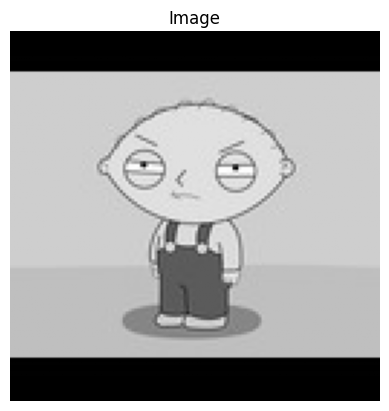

In [4]:
import matplotlib.pyplot as plt

if image_array is not None:
    plt.imshow(image_array, cmap='gray')
    plt.title("Image")
    plt.axis('off')
    plt.show()

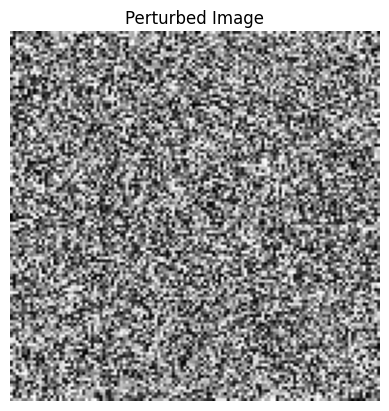

In [5]:
import matplotlib.pyplot as plt

if perturbed_array is not None:
    plt.imshow(perturbed_array, cmap='gray')
    plt.title("Perturbed Image")
    plt.axis('off')
    plt.show()

In [6]:
#perturbated array -> EDNN -> ENCRYPTED -> DDNN -> inverse perturbation -> inv subs -> decrypted img
from PIL import Image
from file import LogisticMap,EDNN,DDNN,ImageEncryptionSystem,generate_dct_matrix,load_and_prepare_image


#### get key from key_generation.py

In [7]:
from key_generation import key_gen

In [8]:
image = Image.open("images.jpg")
image = image.resize((256,256))
key_bytes, key_string = key_gen(image)

In [9]:
len(key_bytes)

32

#### apply aes encryption and decryption

In [10]:
from aes import encrypt_array, decrypt_array

Original Array:
 [[140  66 190 188]
 [168 232  47 220]
 [ 70  92 124 209]
 [ 45 219  65  85]]

Encrypted (base64): FR4l7jB95epaHua0ysEY8EARs2IX7cagaAILkEMAO5I=

Decrypted Array:
 [[140  66 190 188]
 [168 232  47 220]
 [ 70  92 124 209]
 [ 45 219  65  85]]

Match: True


In [11]:
encrypted, iv, shape, dtype = encrypt_array(perturbed_array, key_bytes)

In [12]:
decrypted_array = decrypt_array(encrypted, iv, key_bytes, shape, dtype)


#### INVERSE PERTURBATION

In [13]:
# parameters previously used
seed_d=12345
seed_f=67890
r=3.99
x=0.5

In [14]:
    
pp2 = PixelPerturbation(r_init=r, x_init=x)
pp2.x_original = x
    

In [15]:

inv_perturbed_array = pp2.perturbate_image_inverse(decrypted_array.copy())


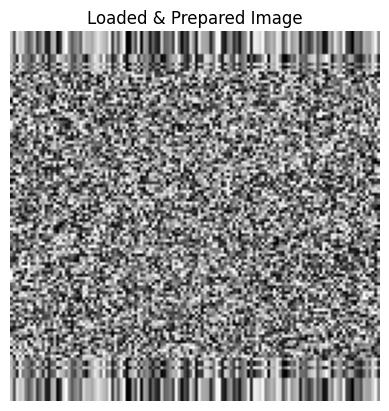

In [16]:
import matplotlib.pyplot as plt

if inv_perturbed_array is not None:
    plt.imshow(inv_perturbed_array, cmap='gray')
    plt.title("Loaded & Prepared Image")
    plt.axis('off')
    plt.show()


#### INVERSE Substitution

In [17]:
fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
recovered_array = np.zeros_like(inv_perturbed_array)


In [18]:
height, width = inv_perturbed_array.shape


In [19]:
for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_perturbed_array[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array[i, :] = recovered_row
    

  Processing row 0/128
  Processing row 50/128
  Processing row 100/128


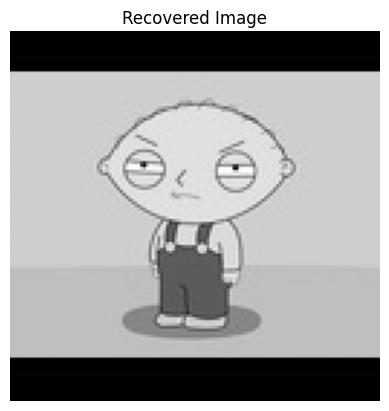

In [20]:
import matplotlib.pyplot as plt

if recovered_array is not None:
    plt.imshow(recovered_array, cmap='gray')
    plt.title("Recovered Image")
    plt.axis('off')
    plt.show()
